Написал лабу, не сохранил, а коммиту видимо оказалось лень сохранять. Переписываю по новой (плачу)
Бизнес-цели:
Определить, какие факторы влияют на величину страховых взносов (Charges) — помощь в разработке персонализированных страховых предложений.
Предсказать вероятность того, что человек является курильщиком (Smoker) — для выявления групп риска и оптимизации страховых тарифов.
Технические цели:
Построить модель регрессии для предсказания величины взносов на основе других признаков.
Построить модель классификации для определения вероятности курения на основе доступных данных.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка датасета
df = pd.read_csv("..//datasets//Lab_1//Medical_insurance.csv", sep=",")

# Удаление пропусков и выбор целевых данных для бизнес-целей
columns_to_use = ["age", "sex", "bmi", "children", "smoker", "region", "charges"]
filtered_data = df[columns_to_use].dropna()

# Цель 1: Регрессия (Charges)
X_reg = filtered_data.drop(columns=["charges"])
y_reg = filtered_data["charges"]

# Цель 2: Классификация (Smoker)
X_clf = filtered_data.drop(columns=["smoker", "charges"])
y_clf = filtered_data["smoker"]

# Разбиение данных для регрессии
X_reg_train, X_reg_temp, y_reg_train, y_reg_temp = train_test_split(X_reg, y_reg, test_size=0.4, random_state=42)
X_reg_val, X_reg_test, y_reg_val, y_reg_test = train_test_split(X_reg_temp, y_reg_temp, test_size=0.5, random_state=42)

# Разбиение данных для классификации
X_clf_train, X_clf_temp, y_clf_train, y_clf_temp = train_test_split(X_clf, y_clf, test_size=0.4, random_state=42, stratify=y_clf)
X_clf_val, X_clf_test, y_clf_val, y_clf_test = train_test_split(X_clf_temp, y_clf_temp, test_size=0.5, random_state=42, stratify=y_clf_temp)

# Проверка размера выборок
print("Регрессия:")
print(f"Обучающая выборка: {X_reg_train.shape}, Контрольная: {X_reg_val.shape}, Тестовая: {X_reg_test.shape}")
print("Классификация:")
print(f"Обучающая выборка: {X_clf_train.shape}, Контрольная: {X_clf_val.shape}, Тестовая: {X_clf_test.shape}")


Регрессия:
Обучающая выборка: (1663, 6), Контрольная: (554, 6), Тестовая: (555, 6)
Классификация:
Обучающая выборка: (1663, 5), Контрольная: (554, 5), Тестовая: (555, 5)


Оцениваем сбалансированность

Распределение классов для классификации:


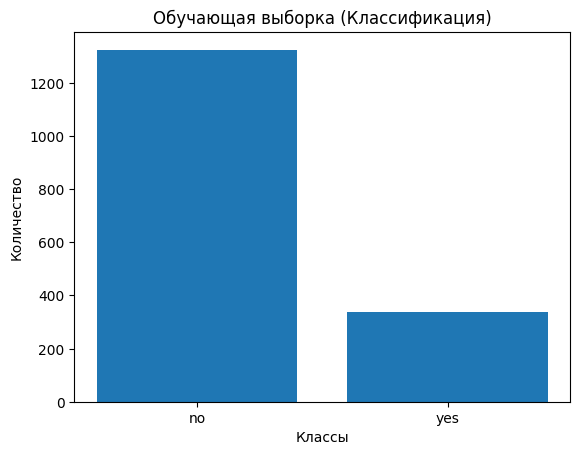

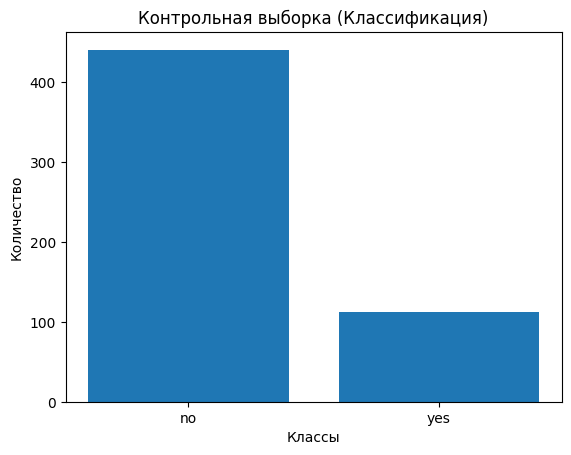

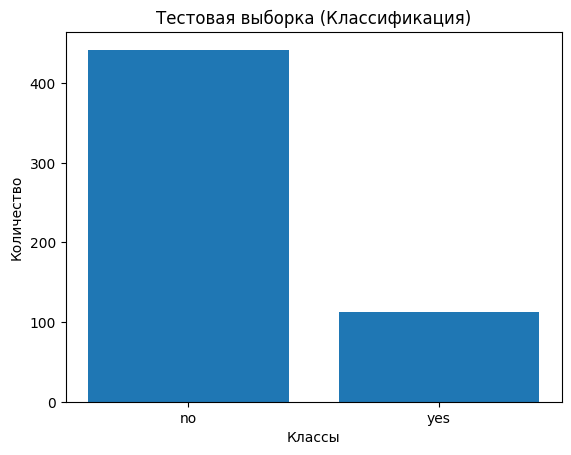

Распределение целевой переменной для регрессии:


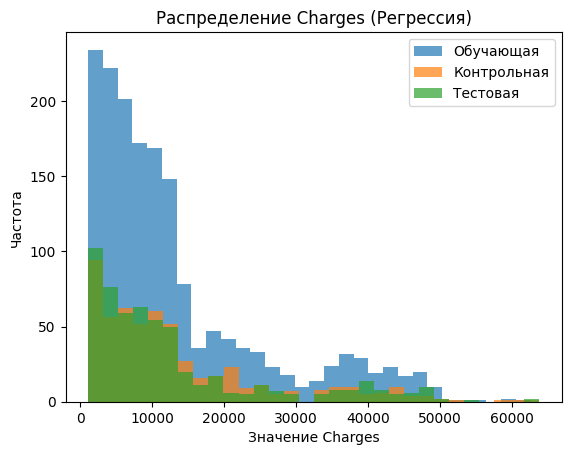

In [3]:
import matplotlib.pyplot as plt

# Функция для визуализации распределения целевой переменной
def plot_balance(y, title):
    counts = y.value_counts()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel("Классы")
    plt.ylabel("Количество")
    plt.show()

# Для классификации (Smoker)
print("Распределение классов для классификации:")
plot_balance(y_clf_train, "Обучающая выборка (Классификация)")
plot_balance(y_clf_val, "Контрольная выборка (Классификация)")
plot_balance(y_clf_test, "Тестовая выборка (Классификация)")

# Для регрессии (Charges) - визуализация распределения через гистограмму
print("Распределение целевой переменной для регрессии:")
plt.hist(y_reg_train, bins=30, alpha=0.7, label="Обучающая")
plt.hist(y_reg_val, bins=30, alpha=0.7, label="Контрольная")
plt.hist(y_reg_test, bins=30, alpha=0.7, label="Тестовая")
plt.title("Распределение Charges (Регрессия)")
plt.xlabel("Значение Charges")
plt.ylabel("Частота")
plt.legend()
plt.show()


Несбалансированно, нужно исправлять

Распределение классов после балансировки:
smoker
no     50.0
yes    50.0
Name: proportion, dtype: float64


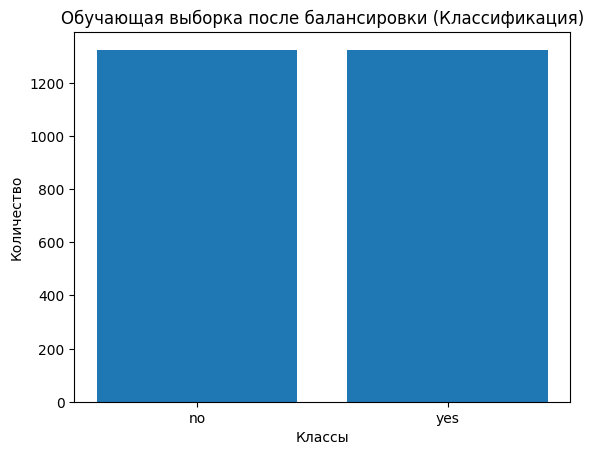

In [5]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Кодирование категориальных признаков
label_encoders = {}
for column in ["sex", "region"]:  # Категориальные столбцы
    le = LabelEncoder()
    X_clf_train[column] = le.fit_transform(X_clf_train[column])
    label_encoders[column] = le

# Применение SMOTE
smote = SMOTE(random_state=42)
X_clf_train_balanced, y_clf_train_balanced = smote.fit_resample(X_clf_train, y_clf_train)

# Проверка нового распределения классов
print("Распределение классов после балансировки:")
balanced_counts = y_clf_train_balanced.value_counts(normalize=True) * 100
print(balanced_counts)

# Визуализация распределения после балансировки
plot_balance(y_clf_train_balanced, "Обучающая выборка после балансировки (Классификация)")


Вот теперь лучше, идем дальше, балансируем другую

До балансировки: (1663, 6) (1663,)
После балансировки: (1665, 6) (1665,)


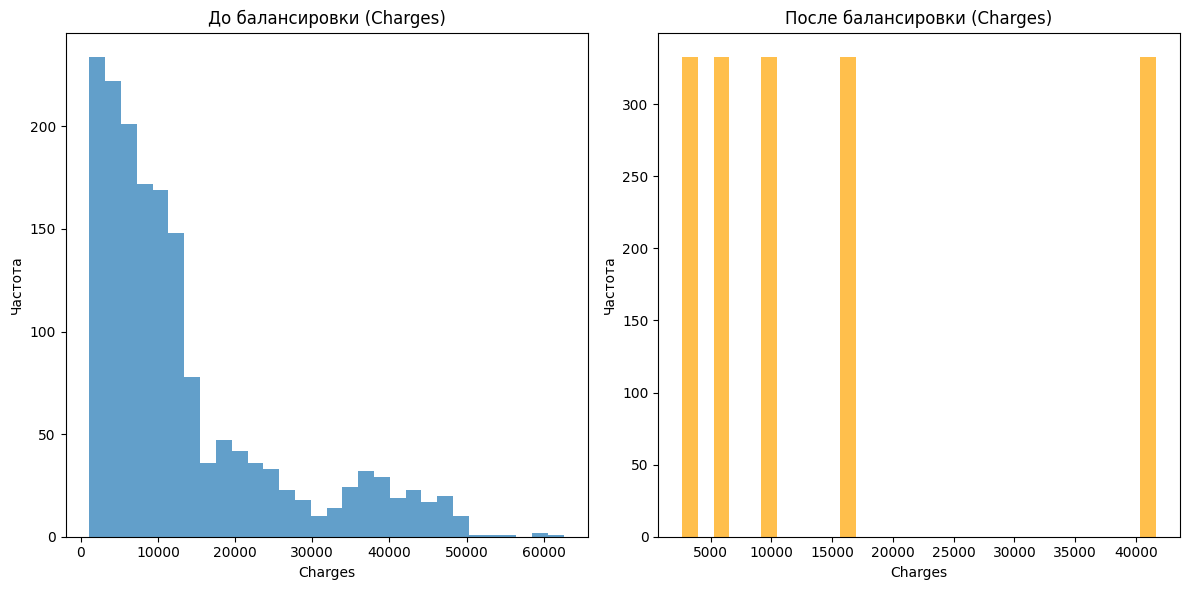

In [9]:
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from imblearn.over_sampling import RandomOverSampler

label_encoders = {}
for column in ["sex", "region","smoker"]:  # Категориальные столбцы
    le = LabelEncoder()
    X_reg_train[column] = le.fit_transform(X_reg_train[column])
    label_encoders[column] = le

# Дискретизация целевой переменной (разбиение на интервалы)
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', random_state=222)  # 5 бинов
y_reg_binned = kbins.fit_transform(y_reg_train.values.reshape(-1, 1)).ravel()

# Масштабирование признаков
scaler = StandardScaler()
X_reg_train_scaled = scaler.fit_transform(X_reg_train)  # Масштабируем данные

# Применение RandomOverSampler для сбалансированного распределения бинов
ros = RandomOverSampler(random_state=42)
X_reg_balanced, y_reg_binned_balanced = ros.fit_resample(X_reg_train_scaled, y_reg_binned)

# Преобразование сбалансированных данных обратно в непрерывные значения (если требуется)
y_reg_balanced = kbins.inverse_transform(y_reg_binned_balanced.reshape(-1, 1)).ravel()

# Проверка форм данных
print("До балансировки:", X_reg_train.shape, y_reg_train.shape)
print("После балансировки:", X_reg_balanced.shape, y_reg_balanced.shape)

# Визуализация распределения целевой переменной
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_reg_train, bins=30, alpha=0.7)
plt.title("До балансировки (Charges)")
plt.xlabel("Charges")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
plt.hist(y_reg_balanced, bins=30, alpha=0.7, color="orange")
plt.title("После балансировки (Charges)")
plt.xlabel("Charges")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()


Отлично, приступаем к конструированию признаков

In [11]:
import featuretools as ft
# One-Hot Encoding для категориальных признаков
categorical_columns = ["sex", "region"]
X_reg_balanced_df = pd.DataFrame(X_reg_balanced, columns=X_reg_train.columns)
X_encoded = pd.get_dummies(X_reg_balanced_df, columns=categorical_columns, drop_first=True)

print("После One-Hot Encoding:")
print(X_encoded.head())

# Дискретизация числовых признаков
X_encoded["Age_bins"] = pd.cut(X_encoded["age"], bins=5, labels=False)
X_encoded["BMI_bins"] = pd.cut(X_encoded["bmi"], bins=5, labels=False)

print("После дискретизации:")
print(X_encoded.head())

# Добавление новых признаков
X_encoded["Children_BMI"] = X_encoded["children"] * X_encoded["bmi"]  # Произведение детей и BMI
X_encoded["Age_BMI_ratio"] = X_encoded["age"] / (X_encoded["bmi"] + 1)  # Возраст на индекс массы тела

print("После синтеза признаков:")
print(X_encoded.head())

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Нормализация
scaler_minmax = MinMaxScaler()
X_normalized = scaler_minmax.fit_transform(X_encoded)

# Стандартизация
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X_encoded)

print("Масштабирование завершено.")

# Создание объекта EntitySet
es = ft.EntitySet(id="charge_data")
es = es.add_dataframe(dataframe_name="charge_data", dataframe=X_encoded, index="charge_id")

# Применяем deep feature synthesis для создания новых признаков
features, feature_names = ft.dfs(entityset=es, target_dataframe_name="charge_data", max_depth=2)

print("Сгенерированные признаки:")
print(features.head())



После One-Hot Encoding:
        age       bmi  children    smoker  sex_0.9501294624541127  \
0  1.266573  0.156259 -0.919952 -0.514431                    True   
1  0.475349  0.280861  0.721550 -0.514431                   False   
2 -0.531664 -1.137311 -0.099201 -0.514431                   False   
3  0.187631 -0.740551 -0.099201  1.943897                    True   
4 -1.179029  0.133306 -0.919952  1.943897                   False   

   region_-0.4674261144497567  region_0.43960962455834773  \
0                        True                       False   
1                       False                       False   
2                       False                        True   
3                       False                        True   
4                       False                       False   

   region_1.3466453635664521  
0                      False  
1                      False  
2                      False  
3                      False  
4                       True  
После ди

c:\repos\AIM\AIM-PIbd-31-Sagirov-M-M\aimenv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index charge_id not found in dataframe, creating new integer column
  warnings.warn(
c:\repos\AIM\AIM-PIbd-31-Sagirov-M-M\aimenv\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Появляются предупреждения, о том что в EntitySet только один датафрейм, игнорируем

Делаем то же самое для другого датасета

In [17]:
import featuretools as ft
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# One-Hot Encoding для категориальных признаков
categorical_columns = ["sex", "region"]
X_clf_balanced_df = pd.DataFrame(X_clf_train_balanced, columns=X_clf_train.columns)
X_encoded = pd.get_dummies(X_clf_balanced_df, columns=categorical_columns, drop_first=True)

print("После One-Hot Encoding:")
print(X_encoded.head())

# Дискретизация числовых признаков
X_encoded["Age_bins"] = pd.cut(X_encoded["age"], bins=5, labels=False)
X_encoded["BMI_bins"] = pd.cut(X_encoded["bmi"], bins=5, labels=False)

print("После дискретизации:")
print(X_encoded.head())

# Синтез новых признаков
X_encoded["Age_BMI"] = X_encoded["age"] * X_encoded["bmi"]  
X_encoded["Age_BMI_ratio"] = X_encoded["age"] / (X_encoded["bmi"] + 1e-6)  #чтоб не бесконечность

print("После синтеза признаков:")
print(X_encoded.head())


# Масштабирование признаков: Стандартизация
scaler = StandardScaler()
X_encoded[['age', 'bmi', 'Age_BMI', 'Age_BMI_ratio']] = scaler.fit_transform(X_encoded[['age', 'bmi', 'Age_BMI', 'Age_BMI_ratio']])

# Масштабирование признаков: Нормализация
scaler_minmax = MinMaxScaler()
X_encoded[['age', 'bmi', 'Age_BMI', 'Age_BMI_ratio']] = scaler_minmax.fit_transform(X_encoded[['age', 'bmi', 'Age_BMI', 'Age_BMI_ratio']])

# Проверка после масштабирования
print(X_encoded.head())


# Создание объекта EntitySet
es = ft.EntitySet(id="smoker_data")
es = es.add_dataframe(dataframe_name="smoker_data", dataframe=X_encoded, index="smoker_id")

# Применяем deep feature synthesis для создания новых признаков
features, feature_names = ft.dfs(entityset=es, target_dataframe_name="smoker_data", max_depth=2)

print("Сгенерированные признаки:")
print(features.head())





После One-Hot Encoding:
   age     bmi  children  sex_1  region_1  region_2  region_3
0   41  32.200         1  False     False     False      True
1   64  22.990         0  False     False      True     False
2   54  27.645         1  False      True     False     False
3   28  26.315         3  False      True     False     False
4   27  30.400         3  False      True     False     False
После дискретизации:
   age     bmi  children  sex_1  region_1  region_2  region_3  Age_bins  \
0   41  32.200         1  False     False     False      True         2   
1   64  22.990         0  False     False      True     False         4   
2   54  27.645         1  False      True     False     False         3   
3   28  26.315         3  False      True     False     False         1   
4   27  30.400         3  False      True     False     False         0   

   BMI_bins  
0         2  
1         0  
2         1  
3         1  
4         1  
После синтеза признаков:
   age     bmi  childre

c:\repos\AIM\AIM-PIbd-31-Sagirov-M-M\aimenv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index smoker_id not found in dataframe, creating new integer column
  warnings.warn(
c:\repos\AIM\AIM-PIbd-31-Sagirov-M-M\aimenv\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Те же самые предупреждения, не обращаем внимания. Приступаем к оценке

Accuracy: 0.8882882882882883
ROC-AUC: 0.8528610899771755
Время обучения модели: 0.2450 секунд
Время предсказания: 0.0123 секунд
Средняя точность по кросс-валидации: 0.9989
Корреляция признаков с целевой переменной:
smoker      1.000000
sex         0.082326
bmi         0.011489
children    0.006362
region     -0.006751
age        -0.023286
Name: smoker, dtype: float64


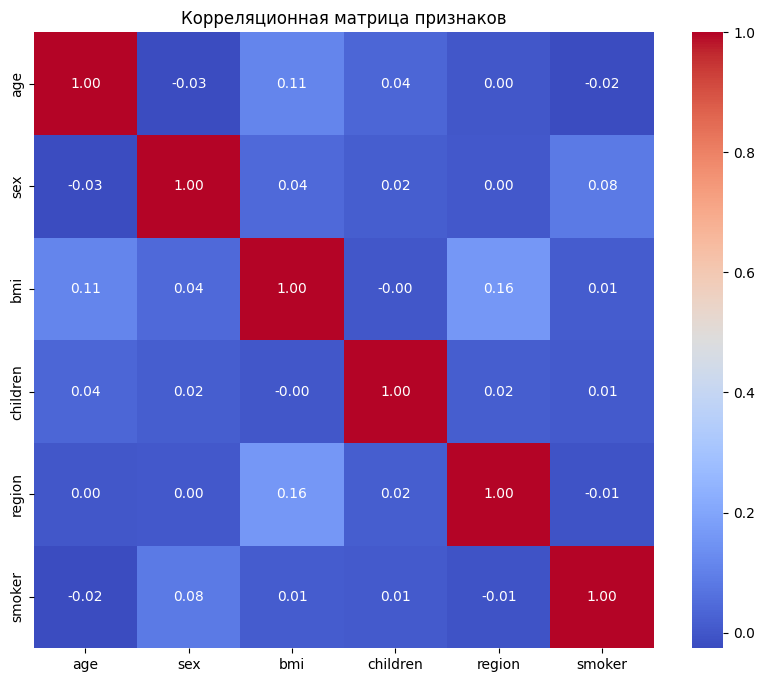

              precision    recall  f1-score   support

          no       0.91      0.96      0.93       442
         yes       0.79      0.62      0.69       113

    accuracy                           0.89       555
   macro avg       0.85      0.79      0.81       555
weighted avg       0.88      0.89      0.88       555



In [23]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Кодирование категориальных признаков
label_encoders = {}
for column in ["sex", "region"]:  # Категориальные столбцы
    le = LabelEncoder()
    X_clf_test[column] = le.fit_transform(X_clf_test[column])
    X_clf_train[column] = le.fit_transform(X_clf_train[column])
    X_clf[column] = le.fit_transform(X_clf[column])
    label_encoders[column] = le

# 1. Оценка предсказательной способности (Accuracy и ROC-AUC для бинарной классификации)
model = RandomForestClassifier(random_state=42)

start_time = time.perf_counter()
model.fit(X_clf_train, y_clf_train)
end_time = time.perf_counter()

train_time = end_time - start_time

y_pred = model.predict(X_clf_test)
accuracy = accuracy_score(y_clf_test, y_pred)
roc_auc = roc_auc_score(y_clf_test, model.predict_proba(X_clf_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"Время обучения модели: {train_time:.4f} секунд")

# 2. Оценка скорости вычисления (время предсказания)
start_time = time.perf_counter()
y_pred = model.predict(X_clf_test)
end_time = time.perf_counter()
predict_time = end_time - start_time

print(f"Время предсказания: {predict_time:.4f} секунд")

# 3. Оценка надежности модели с помощью перекрестной проверки
cv_scores = cross_val_score(model, X_clf, y_clf, cv=5, scoring='accuracy')
mean_cv_score = np.mean(cv_scores)
print(f"Средняя точность по кросс-валидации: {mean_cv_score:.4f}")

# 4. Оценка корреляции признаков с целевой переменной
# Сначала нужно закодировать целевую переменную, если она не числовая
if y_clf.dtypes == 'object':
    y_clf = LabelEncoder().fit_transform(y_clf)
if isinstance(y_clf, np.ndarray):
    y_clf = pd.Series(y_clf)

# Преобразуем y_clf в DataFrame с названием 'smoker'
y_clf = pd.Series(y_clf, name='smoker')

# Объединяем X_clf с y_clf
correlation_matrix = pd.concat([X_clf, y_clf], axis=1).corr()

# Корреляция признаков с целевой переменной (столбец 'smoker')
correlation_with_target = correlation_matrix['smoker'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной:")
print(correlation_with_target)

# Визуализация корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.show()

# Дополнительная информация о модели
print(classification_report(y_clf_test, y_pred))


Вроде всё, мораль такова - используйте ctrl+s